In [2]:
%pylab inline

import math
import os
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.misc import imread

Populating the interactive namespace from numpy and matplotlib
Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
seed = 128
rng = np.random.RandomState(seed)

In [4]:
root_dir = os.path.abspath('D:\ML Projects\Handwritten Digits Classification')

In [5]:
os.chdir('D:\ML Projects\Handwritten Digits Classification')

In [6]:
os.getcwd()

'D:\\ML Projects\\Handwritten Digits Classification'

In [7]:
train = pd.read_csv(os.path.join(root_dir, "train.csv"))
test = pd.read_csv(os.path.join(root_dir, "test.csv"))

sample_sub = pd.read_csv(os.path.join(root_dir, "sample_submission.csv"))

test.head()

,filename
0,49000.png
1,49001.png
2,49002.png
3,49003.png
4,49004.png


D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


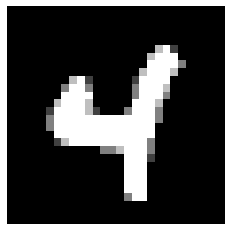

In [34]:
img_name = rng.choice(train.filename)
filepath = os.path.join(root_dir, 'Images', 'train', img_name)
img = imread(filepath, flatten=False)

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

In [9]:
img.shape

(28, 28, 4)

In [10]:
temp = []

for img_name in train.filename:
    image_path = os.path.join(root_dir, 'Images', 'train', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype(float32)
    temp.append(img)

X_train_orig = np.stack(temp)

temp = []

for img_name in test.filename:
    image_path = os.path.join(root_dir, 'Images', 'test', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype(float32)
    temp.append(img)
    
X_test_orig = np.stack(temp)
Y_train_orig = train.label.values[:].reshape(1, X_train_orig.shape[0])
Y_train_orig.shape

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


(1, 49000)

In [11]:
X_test_orig.shape

(21000, 28, 28)

In [12]:
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

X_train_init = X_train_flatten / X_train_flatten.max()
X_test_init = X_test_flatten / X_train_flatten.max()

split = int(X_train_orig.shape[0] * 0.7)

X_train, X_val = X_train_init[:, :split], X_train_init[:, split:]
Y_train_init, Y_val_init = Y_train_orig[:, :split], Y_train_orig[:, split:]
Y_val_init.shape

(1, 14700)

In [13]:
def one_hot_matrix(labels, C):
    C = tf.constant(C, name = "C")
    one_hot_matrix = tf.one_hot(labels, C, axis=0)
    
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    
    return one_hot

In [14]:
Y_train = one_hot_matrix(Y_train_init, 10).reshape(10, X_train.shape[1])
Y_val = one_hot_matrix(Y_val_init, 10).reshape(10, X_val.shape[1])
Y_val.shape

(10, 14700)

In [15]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed)
    m = X.shape[1]
    minibatches = []
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    
    num_complete_minibatches = math.floor(m/mini_batch_size)
    
    for k in range(0, num_complete_minibatches):
        minibatch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        minibatch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        
        minibatch = (minibatch_X, minibatch_Y)
        minibatches.append(minibatch)
    
    if m%mini_batch_size != 0:
        minibatch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size :]
        minibatch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size :]
        minibatch = (minibatch_X, minibatch_Y)
        minibatches.append(minibatch)
        
    return minibatches

In [16]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    
    return X, Y

In [17]:
def initialize_parameters(layers_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims)
    
    for l in range(1, L):
        parameters['W' + str(l)] = tf.Variable(initial_value=tf.random_normal([layers_dims[l], layers_dims[l-1]], dtype=tf.float32)* 0.01)
        parameters['b' + str(l)]=tf.Variable(initial_value=tf.zeros([layers_dims[l],1],dtype=tf.float32) * 0.01)
        
        
    return parameters

In [18]:
def forward_propagation(X, parameters):
    L = len(parameters) // 2
    A = X
    
    for l in range(L):
        A_prev = A
        Z = tf.matmul(parameters["W" + str(l+1)], A_prev) + parameters["b" + str(l+1)]
        A = tf.nn.relu(Z)
        
    ZL = tf.matmul(parameters["W" + str(L)], A_prev) + parameters["b" + str(L)]
    return ZL

In [19]:
def compute_cost(ZL, Y):
    logits = tf.transpose(ZL)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    return cost

In [71]:
def model(X_train, Y_train, X_val, Y_val, learning_rate = 0.003, num_epochs = 200, hidden_units = 500, minibatch_size = 128, print_cost=True):
    seed = 3
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    layers_dims = [n_x, hidden_units, n_y]
    costs = []
    
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters(layers_dims)
    ZL = forward_propagation(X, parameters)
    cost = compute_cost(ZL, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / minibatch_size
                
            if print_cost and epoch%100 == 0:
                print("Cost after epoch %i: %f"%(epoch, epoch_cost))
            if print_cost and epoch%5 == 0:
                costs.append(epoch_cost)
            
        plt.plot(np.squeeze(costs))
        plt.ylabel("Cost")
        plt.xlabel("Iterations (per fives)")
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()
        
        parameters = sess.run(parameters)
        print("Parameters trained!")
        
        correct_prediction = tf.equal(tf.argmax(ZL), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, float))
        
        print("Train Accuracy: ", accuracy.eval({X: X_train, Y: Y_train}))
        print("Cross-Validation Accuracy: ", accuracy.eval({X: X_val, Y: Y_val}))
        
        return parameters

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 0.537656


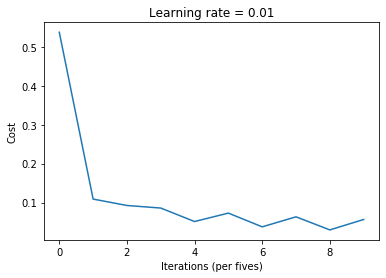

Parameters trained!
Train Accuracy:  0.99504375
Cross-Validation Accuracy:  0.9702721


In [20]:
parameters = model(X_train, Y_train, X_val, Y_val, num_epochs=50)

Learning rate: 0.001


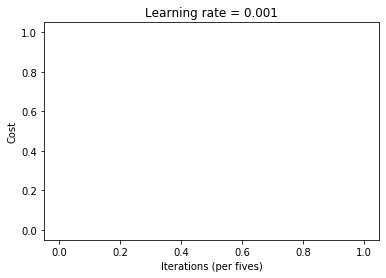

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9767347
Learning rate: 0.003


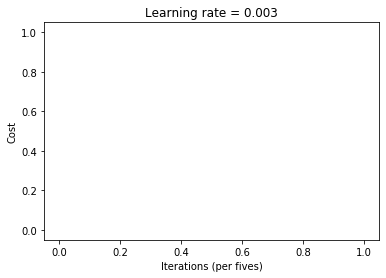

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97931975
Learning rate: 0.01


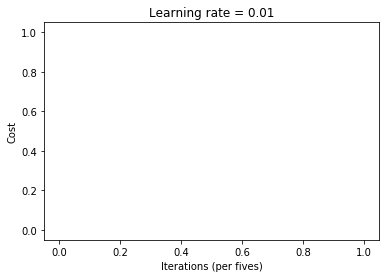

Parameters trained!
Train Accuracy:  0.99521863
Cross-Validation Accuracy:  0.96863943
Learning rate: 0.03


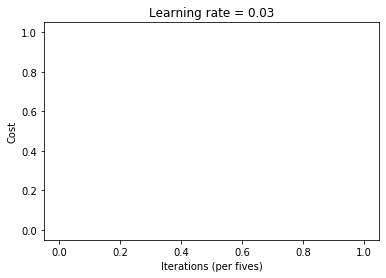

Parameters trained!
Train Accuracy:  0.9770262
Cross-Validation Accuracy:  0.94673467
Learning rate: 0.1


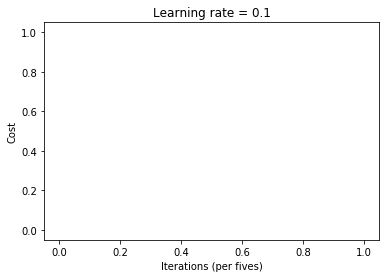

Parameters trained!
Train Accuracy:  0.85973763
Cross-Validation Accuracy:  0.8445578
Learning rate: 0.3


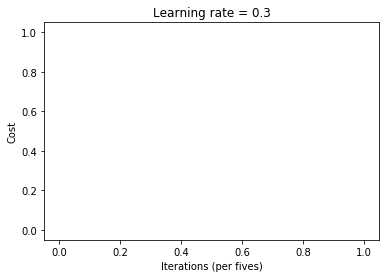

Parameters trained!
Train Accuracy:  0.21548104
Cross-Validation Accuracy:  0.21040817
Learning rate: 1


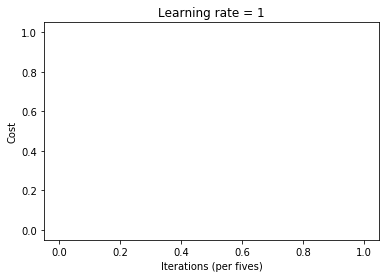

Parameters trained!
Train Accuracy:  0.11344023
Cross-Validation Accuracy:  0.11421768
Learning rate: 3


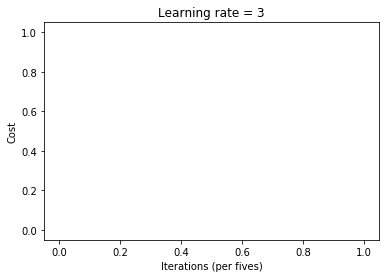

Parameters trained!
Train Accuracy:  0.114052474
Cross-Validation Accuracy:  0.10979592
Learning rate: 10


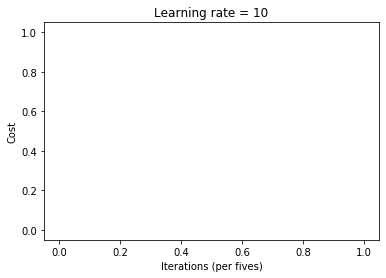

Parameters trained!
Train Accuracy:  0.11046647
Cross-Validation Accuracy:  0.11047619
Learning rate: 30


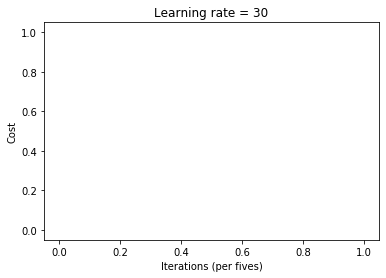

Parameters trained!
Train Accuracy:  0.14851312
Cross-Validation Accuracy:  0.14761905


In [37]:
rates = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
params = {}

for rate in rates:
    print("Learning rate: " + str(rate))
    params[rate] = model(X_train, Y_train, X_val, Y_val, learning_rate=rate, num_epochs=50, print_cost=False)

In [23]:
epochs = [10, 50, 100, 200, 500, 1000, 1500]
params = {}

for epoch in epochs:
    print("\nNo. of epochs: " + str(epoch))
    params[epoch] = model(X_train, Y_train, X_val, Y_val, num_epochs=epoch, print_cost=False)


No. of epochs: 10
Parameters trained!
Train Accuracy:  0.9959184
Cross-Validation Accuracy:  0.97163266

No. of epochs: 50
Parameters trained!
Train Accuracy:  0.9995044
Cross-Validation Accuracy:  0.97591835

No. of epochs: 100
Parameters trained!
Train Accuracy:  0.9990379
Cross-Validation Accuracy:  0.9742857

No. of epochs: 200
Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9802041

No. of epochs: 500
Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97809523

No. of epochs: 1000
Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9791837

No. of epochs: 1500
Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97809523


Cost after epoch 0: 0.660962
Cost after epoch 100: 0.000000


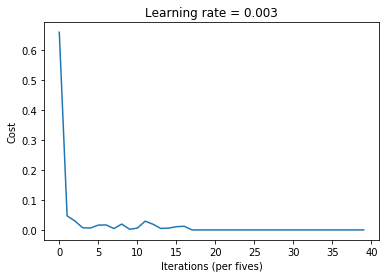

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97911566


In [73]:
parameters = model(X_train, Y_train, X_val, Y_val, hidden_units=525, num_epochs=200)

In [22]:
def predict(X, parameters):
    L = len(parameters) // 2
    params = {}
    
    for l in range(L):
        params["W" + str(l+1)] = tf.convert_to_tensor(parameters["W" + str(l+1)])
        params["b" + str(l+1)] = tf.convert_to_tensor(parameters["b" + str(l+1)])
    
    x = tf.placeholder("float", [28*28, X.shape[1]])
    zL = forward_propagation(x, params)
    p = tf.argmax(zL)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
    
    return prediction

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


Your algorithm predicts: y = 7


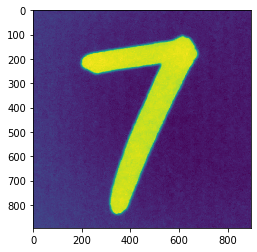

In [43]:
import scipy

my_image = "test_img_6.png"
filepath = os.path.join(root_dir, "Test Images", my_image)
img = imread(filepath, flatten=True)

img = img / img.max()
my_image = scipy.misc.imresize(img, size=(28,28)).reshape((1, 28*28)).T

my_image_prediction = predict(my_image, parameters)

plt.imshow(img)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

In [33]:
prediction = predict(X_test_init, parameters).reshape(X_test_init.shape[1], 1)
prediction.shape

(21000, 1)

In [75]:
sample_sub.filename = test.filename

sample_sub.label = prediction

sample_sub.to_csv(os.path.join(root_dir, "sub02.csv"), index=False)


No. of hidden units: 852

Learning rate: 0.07738767886265063
Cost after epoch 0: 5.310055
Cost after epoch 100: 0.812268


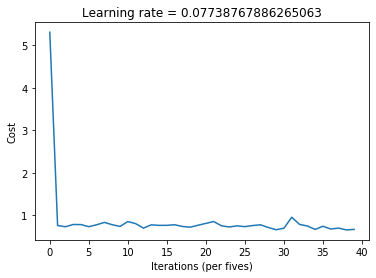

Parameters trained!
Train Accuracy:  0.9044898
Cross-Validation Accuracy:  0.8810204

Learning rate: 0.21262097243064185
Cost after epoch 0: 29.461720
Cost after epoch 100: 3.842081


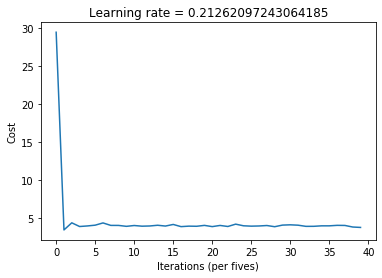

Parameters trained!
Train Accuracy:  0.29982507
Cross-Validation Accuracy:  0.29639456

Learning rate: 0.0011892993902712177
Cost after epoch 0: 0.784378
Cost after epoch 100: 0.000000


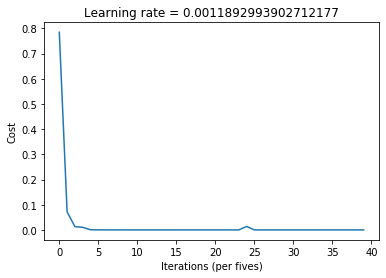

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9785714

Learning rate: 0.001207546650657428
Cost after epoch 0: 0.783149
Cost after epoch 100: 0.000000


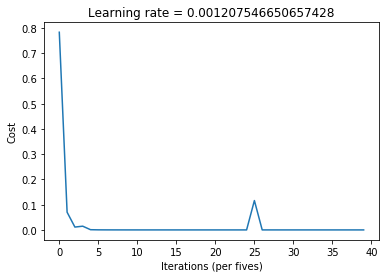

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97938776

Learning rate: 0.0017193215824340233
Cost after epoch 0: 0.705039
Cost after epoch 100: 0.000000


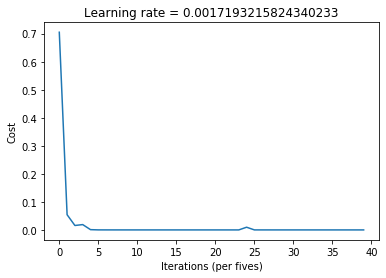

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97911566

Learning rate: 0.0034232833382602675
Cost after epoch 0: 0.573707
Cost after epoch 100: 0.000000


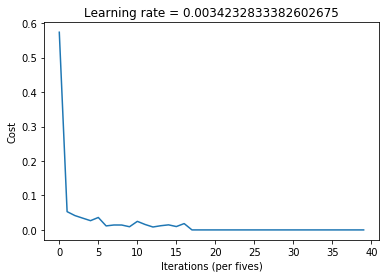

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9790476

Learning rate: 0.6340725780813288
Cost after epoch 0: 329.268584
Cost after epoch 100: 4.876937


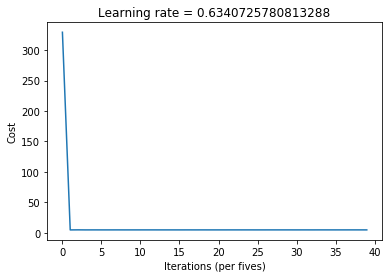

Parameters trained!
Train Accuracy:  0.099446066
Cross-Validation Accuracy:  0.10047619

Learning rate: 0.0019286439209945112
Cost after epoch 0: 0.679337
Cost after epoch 100: 0.000000


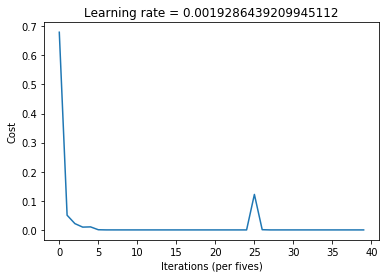

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97945577

Learning rate: 0.4119302380376908
Cost after epoch 0: 151.040614
Cost after epoch 100: 4.733717


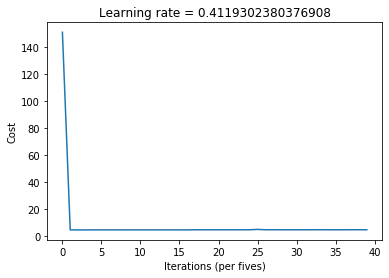

Parameters trained!
Train Accuracy:  0.12294461
Cross-Validation Accuracy:  0.118163265

Learning rate: 0.008288573963901116
Cost after epoch 0: 0.530747
Cost after epoch 100: 0.039098


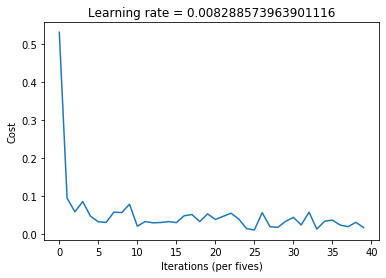

Parameters trained!
Train Accuracy:  0.99912536
Cross-Validation Accuracy:  0.9746258

No. of hidden units: 525

Learning rate: 0.07738767886265063
Cost after epoch 0: 3.920425
Cost after epoch 100: 0.898775


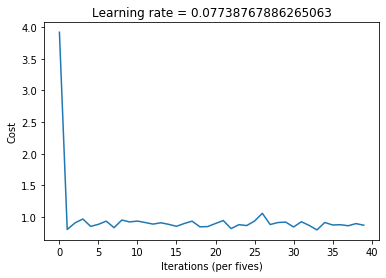

Parameters trained!
Train Accuracy:  0.8776968
Cross-Validation Accuracy:  0.85374147

Learning rate: 0.21262097243064185
Cost after epoch 0: 22.531824
Cost after epoch 100: 2.816740


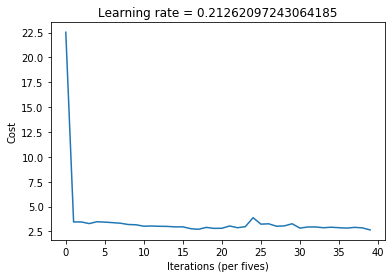

Parameters trained!
Train Accuracy:  0.5059184
Cross-Validation Accuracy:  0.50319725

Learning rate: 0.0011892993902712177
Cost after epoch 0: 0.865387
Cost after epoch 100: 0.000000


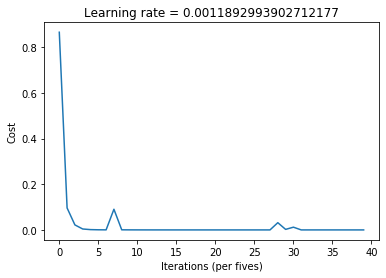

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9770748

Learning rate: 0.001207546650657428
Cost after epoch 0: 0.864519
Cost after epoch 100: 0.000000


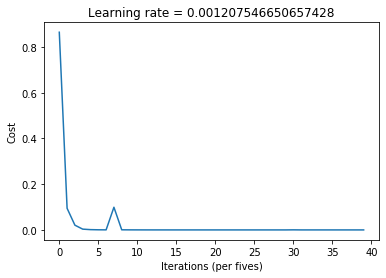

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97734696

Learning rate: 0.0017193215824340233
Cost after epoch 0: 0.769979
Cost after epoch 100: 0.000000


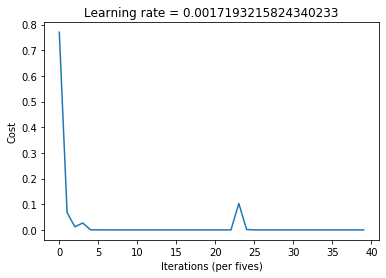

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9785714

Learning rate: 0.0034232833382602675
Cost after epoch 0: 0.635135
Cost after epoch 100: 0.000000


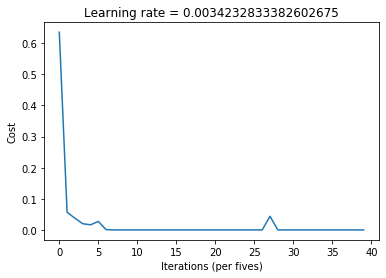

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9788435

Learning rate: 0.6340725780813288
Cost after epoch 0: 192.524304
Cost after epoch 100: 4.856595


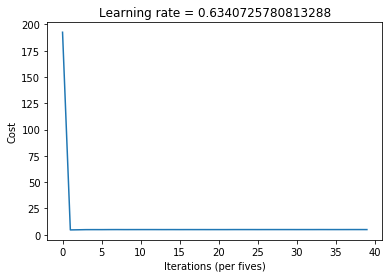

Parameters trained!
Train Accuracy:  0.09941691
Cross-Validation Accuracy:  0.10040817

Learning rate: 0.0019286439209945112
Cost after epoch 0: 0.745058
Cost after epoch 100: 0.000000


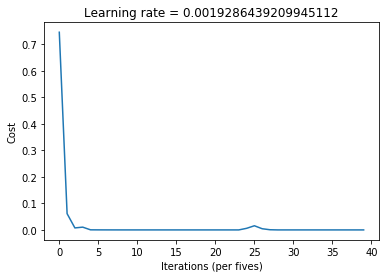

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97795916

Learning rate: 0.4119302380376908
Cost after epoch 0: 80.274909
Cost after epoch 100: 4.858824


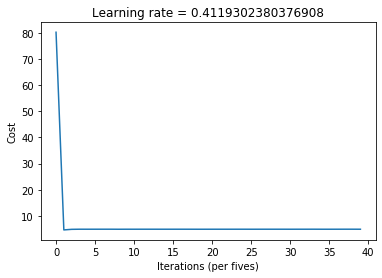

Parameters trained!
Train Accuracy:  0.09918367
Cross-Validation Accuracy:  0.09734694

Learning rate: 0.008288573963901116
Cost after epoch 0: 0.533218
Cost after epoch 100: 0.026538


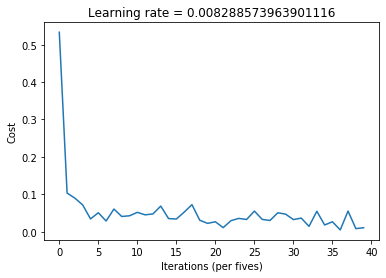

Parameters trained!
Train Accuracy:  0.99912536
Cross-Validation Accuracy:  0.9765306

No. of hidden units: 372

Learning rate: 0.07738767886265063
Cost after epoch 0: 3.283061
Cost after epoch 100: 0.898517


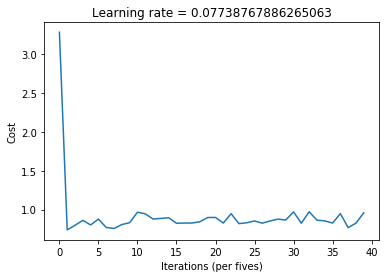

Parameters trained!
Train Accuracy:  0.8891837
Cross-Validation Accuracy:  0.8647619

Learning rate: 0.21262097243064185
Cost after epoch 0: 21.815940
Cost after epoch 100: 3.686397


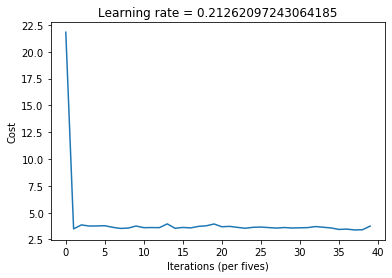

Parameters trained!
Train Accuracy:  0.36137027
Cross-Validation Accuracy:  0.35741496

Learning rate: 0.0011892993902712177
Cost after epoch 0: 0.941691
Cost after epoch 100: 0.000000


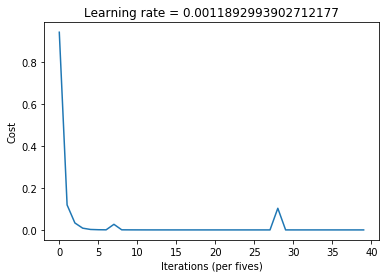

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9769388

Learning rate: 0.001207546650657428
Cost after epoch 0: 0.934028
Cost after epoch 100: 0.000048


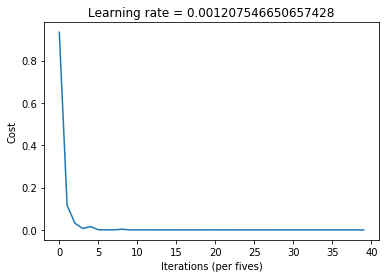

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9769388

Learning rate: 0.0017193215824340233
Cost after epoch 0: 0.825650
Cost after epoch 100: 0.000000


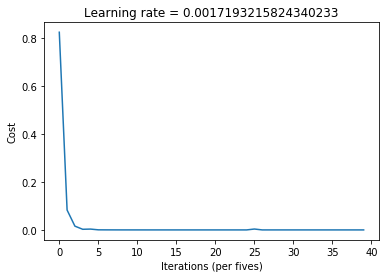

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97809523

Learning rate: 0.0034232833382602675
Cost after epoch 0: 0.673633
Cost after epoch 100: 0.000000


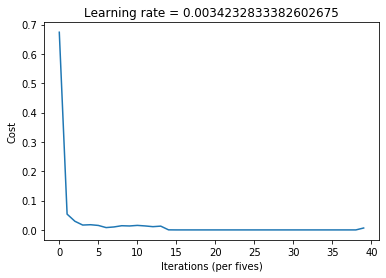

Parameters trained!
Train Accuracy:  0.99997085
Cross-Validation Accuracy:  0.97789115

Learning rate: 0.6340725780813288
Cost after epoch 0: 135.614546
Cost after epoch 100: 4.876916


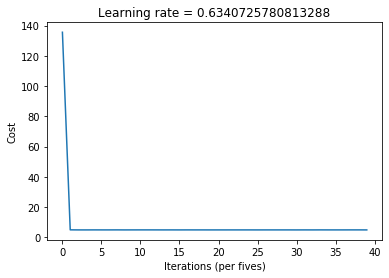

Parameters trained!
Train Accuracy:  0.099446066
Cross-Validation Accuracy:  0.10013606

Learning rate: 0.0019286439209945112
Cost after epoch 0: 0.791950
Cost after epoch 100: 0.000000


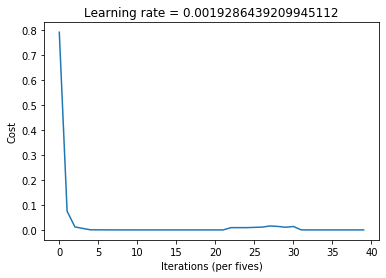

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9782313

Learning rate: 0.4119302380376908
Cost after epoch 0: 51.077632
Cost after epoch 100: 4.758034


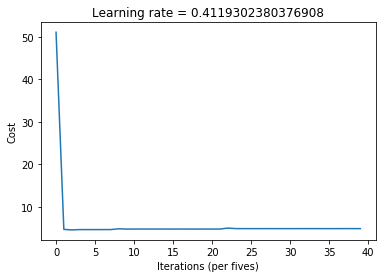

Parameters trained!
Train Accuracy:  0.100174926
Cross-Validation Accuracy:  0.09823129

Learning rate: 0.008288573963901116
Cost after epoch 0: 0.546037
Cost after epoch 100: 0.011167


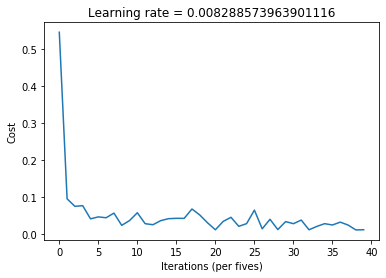

Parameters trained!
Train Accuracy:  0.999242
Cross-Validation Accuracy:  0.9735374

No. of hidden units: 567

Learning rate: 0.07738767886265063
Cost after epoch 0: 4.483385
Cost after epoch 100: 0.774126


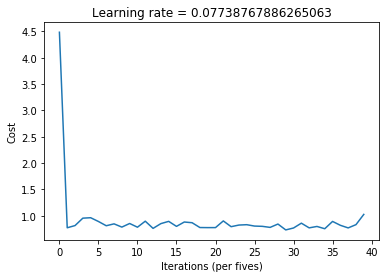

Parameters trained!
Train Accuracy:  0.90944606
Cross-Validation Accuracy:  0.8853061

Learning rate: 0.21262097243064185
Cost after epoch 0: 27.647783
Cost after epoch 100: 3.396243


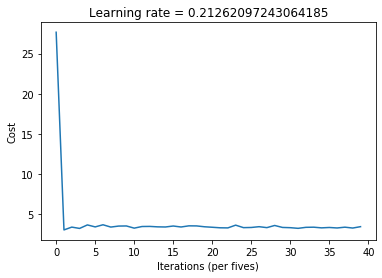

Parameters trained!
Train Accuracy:  0.38632652
Cross-Validation Accuracy:  0.38054422

Learning rate: 0.0011892993902712177
Cost after epoch 0: 0.861368
Cost after epoch 100: 0.000000


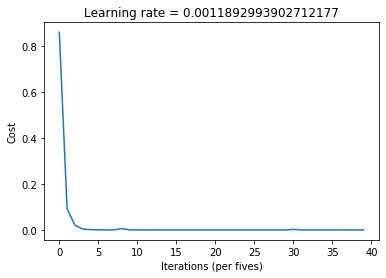

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97768706

Learning rate: 0.001207546650657428
Cost after epoch 0: 0.858466
Cost after epoch 100: 0.000000


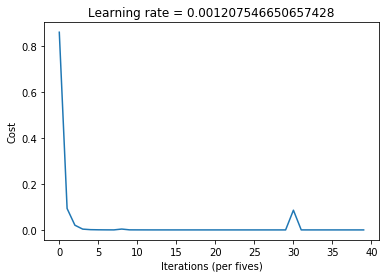

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9770748

Learning rate: 0.0017193215824340233
Cost after epoch 0: 0.764998
Cost after epoch 100: 0.000000


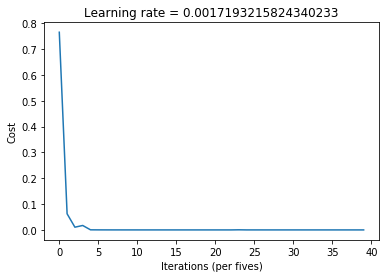

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9788435

Learning rate: 0.0034232833382602675
Cost after epoch 0: 0.624188
Cost after epoch 100: 0.007006


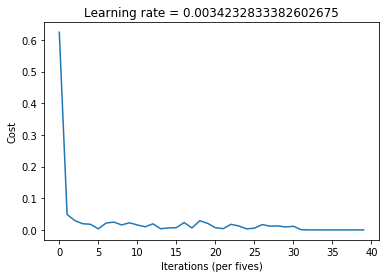

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9768708

Learning rate: 0.6340725780813288
Cost after epoch 0: 209.228640
Cost after epoch 100: 4.875215


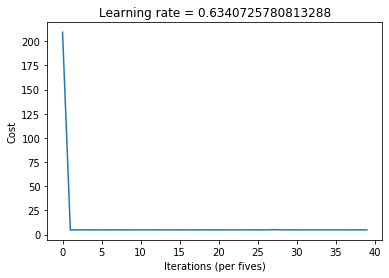

Parameters trained!
Train Accuracy:  0.09924198
Cross-Validation Accuracy:  0.1

Learning rate: 0.0019286439209945112
Cost after epoch 0: 0.734822
Cost after epoch 100: 0.000000


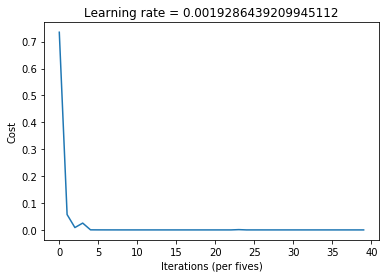

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97755104

Learning rate: 0.4119302380376908
Cost after epoch 0: 66.109099
Cost after epoch 100: 4.786106


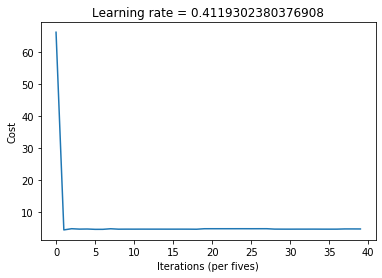

Parameters trained!
Train Accuracy:  0.12953353
Cross-Validation Accuracy:  0.12693878

Learning rate: 0.008288573963901116
Cost after epoch 0: 0.534180
Cost after epoch 100: 0.049351


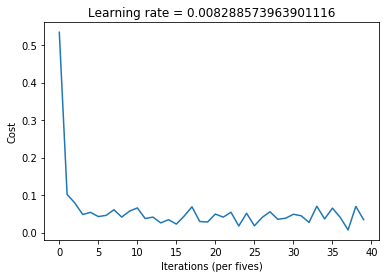

Parameters trained!
Train Accuracy:  0.9995627
Cross-Validation Accuracy:  0.9753061

No. of hidden units: 863

Learning rate: 0.07738767886265063
Cost after epoch 0: 5.440034
Cost after epoch 100: 0.707054


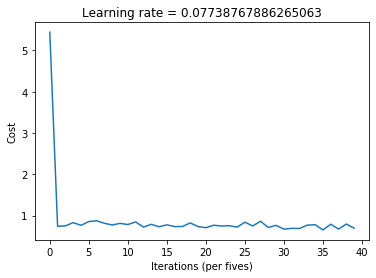

Parameters trained!
Train Accuracy:  0.8919825
Cross-Validation Accuracy:  0.86537415

Learning rate: 0.21262097243064185
Cost after epoch 0: 37.938658
Cost after epoch 100: 3.312883


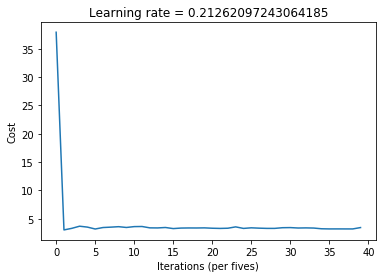

Parameters trained!
Train Accuracy:  0.37655976
Cross-Validation Accuracy:  0.37013605

Learning rate: 0.0011892993902712177
Cost after epoch 0: 0.791125
Cost after epoch 100: 0.000000


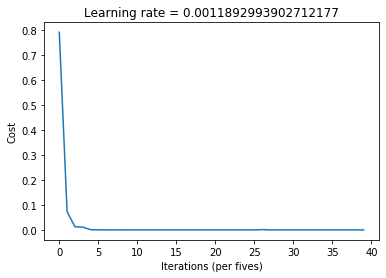

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9785714

Learning rate: 0.001207546650657428
Cost after epoch 0: 0.775828
Cost after epoch 100: 0.000000


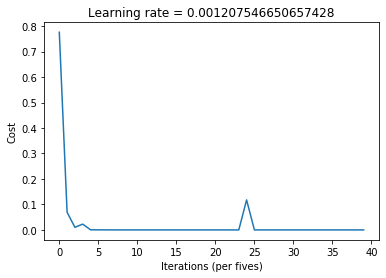

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9785034

Learning rate: 0.0017193215824340233
Cost after epoch 0: 0.692766
Cost after epoch 100: 0.000000


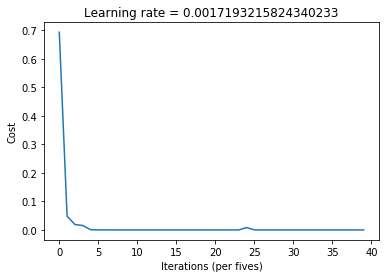

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97931975

Learning rate: 0.0034232833382602675
Cost after epoch 0: 0.577713
Cost after epoch 100: 0.000000


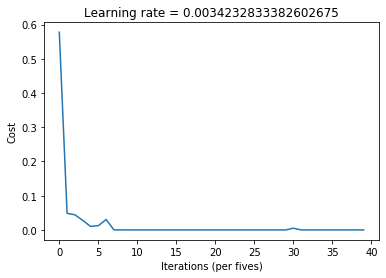

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9785714

Learning rate: 0.6340725780813288
Cost after epoch 0: 320.401901
Cost after epoch 100: 4.866700


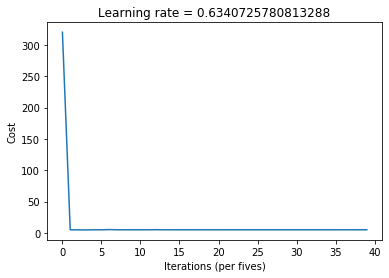

Parameters trained!
Train Accuracy:  0.101195335
Cross-Validation Accuracy:  0.10197279

Learning rate: 0.0019286439209945112
Cost after epoch 0: 0.679903
Cost after epoch 100: 0.000000


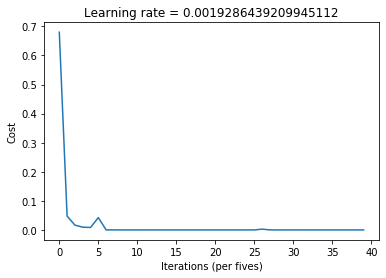

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9808844

Learning rate: 0.4119302380376908
Cost after epoch 0: 143.798107
Cost after epoch 100: 4.745870


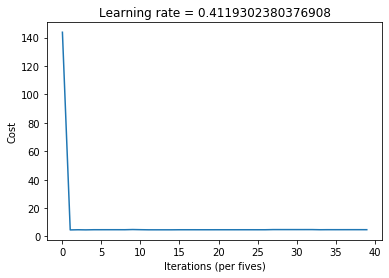

Parameters trained!
Train Accuracy:  0.114139944
Cross-Validation Accuracy:  0.10891157

Learning rate: 0.008288573963901116
Cost after epoch 0: 0.522236
Cost after epoch 100: 0.020046


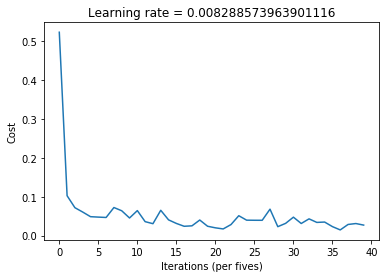

Parameters trained!
Train Accuracy:  0.9998542
Cross-Validation Accuracy:  0.97612244

No. of hidden units: 112

Learning rate: 0.07738767886265063
Cost after epoch 0: 2.112345
Cost after epoch 100: 0.996241


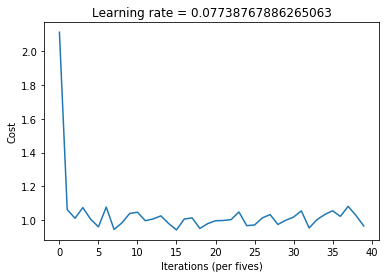

Parameters trained!
Train Accuracy:  0.86431485
Cross-Validation Accuracy:  0.8367347

Learning rate: 0.21262097243064185
Cost after epoch 0: 5.498124
Cost after epoch 100: 3.382341


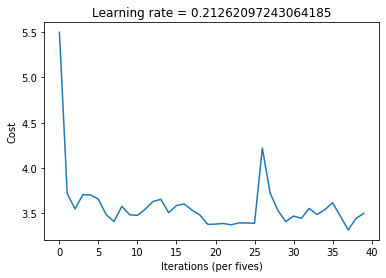

Parameters trained!
Train Accuracy:  0.3796793
Cross-Validation Accuracy:  0.37544218

Learning rate: 0.0011892993902712177
Cost after epoch 0: 1.229992
Cost after epoch 100: 0.000095


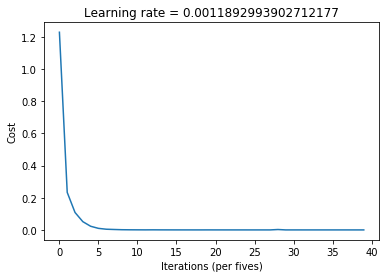

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9729932

Learning rate: 0.001207546650657428
Cost after epoch 0: 1.235208
Cost after epoch 100: 0.000111


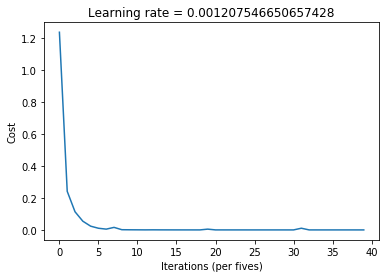

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97238094

Learning rate: 0.0017193215824340233
Cost after epoch 0: 1.072294
Cost after epoch 100: 0.000057


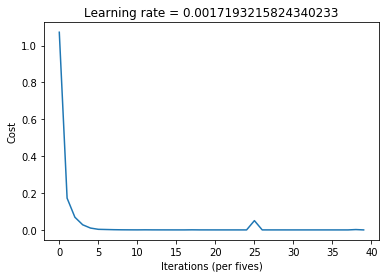

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.972517

Learning rate: 0.0034232833382602675
Cost after epoch 0: 0.858686
Cost after epoch 100: 0.000035


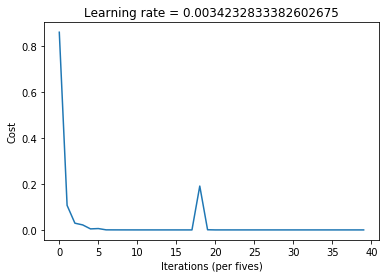

Parameters trained!
Train Accuracy:  0.9990088
Cross-Validation Accuracy:  0.97210884

Learning rate: 0.6340725780813288
Cost after epoch 0: 43.312022
Cost after epoch 100: 4.878205


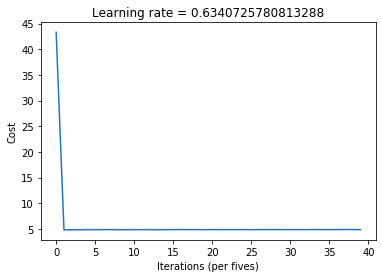

Parameters trained!
Train Accuracy:  0.09918367
Cross-Validation Accuracy:  0.100068025

Learning rate: 0.0019286439209945112
Cost after epoch 0: 1.033412
Cost after epoch 100: 0.000030


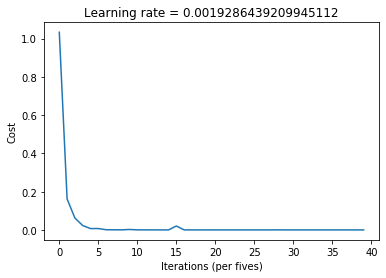

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9734694

Learning rate: 0.4119302380376908
Cost after epoch 0: 16.472938
Cost after epoch 100: 4.855050


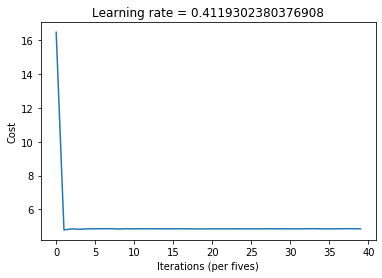

Parameters trained!
Train Accuracy:  0.10005831
Cross-Validation Accuracy:  0.097755104

Learning rate: 0.008288573963901116
Cost after epoch 0: 0.651347
Cost after epoch 100: 0.030417


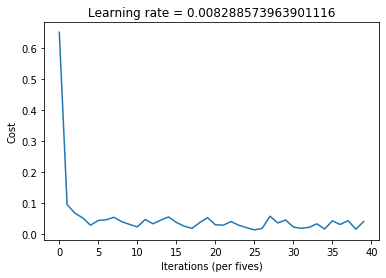

Parameters trained!
Train Accuracy:  0.99932945
Cross-Validation Accuracy:  0.9726531

No. of hidden units: 451

Learning rate: 0.07738767886265063
Cost after epoch 0: 3.339305
Cost after epoch 100: 0.888845


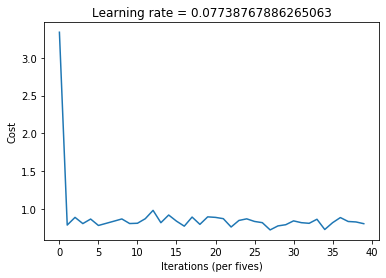

Parameters trained!
Train Accuracy:  0.87446064
Cross-Validation Accuracy:  0.85340136

Learning rate: 0.21262097243064185
Cost after epoch 0: 23.161048
Cost after epoch 100: 3.523668


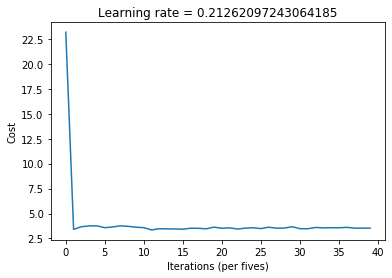

Parameters trained!
Train Accuracy:  0.31565598
Cross-Validation Accuracy:  0.31217688

Learning rate: 0.0011892993902712177
Cost after epoch 0: 0.903293
Cost after epoch 100: 0.000018


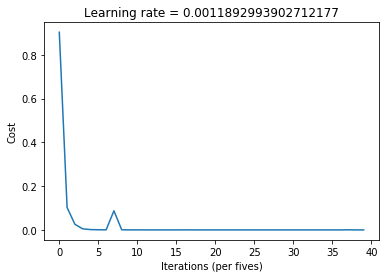

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9772789

Learning rate: 0.001207546650657428
Cost after epoch 0: 0.899964
Cost after epoch 100: 0.000002


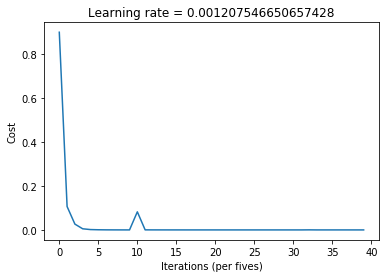

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9782993

Learning rate: 0.0017193215824340233
Cost after epoch 0: 0.793670
Cost after epoch 100: 0.000000


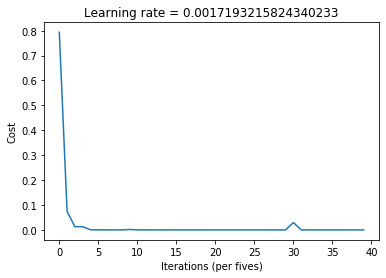

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97761905

Learning rate: 0.0034232833382602675
Cost after epoch 0: 0.653602
Cost after epoch 100: 0.032084


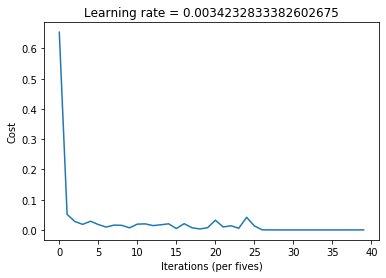

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97755104

Learning rate: 0.6340725780813288
Cost after epoch 0: 146.562141
Cost after epoch 100: 4.875706


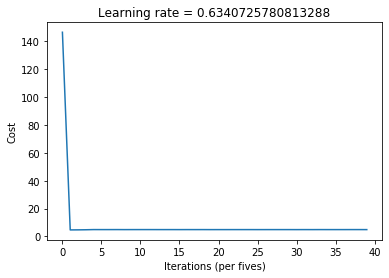

Parameters trained!
Train Accuracy:  0.09959184
Cross-Validation Accuracy:  0.10020408

Learning rate: 0.0019286439209945112
Cost after epoch 0: 0.767405
Cost after epoch 100: 0.000000


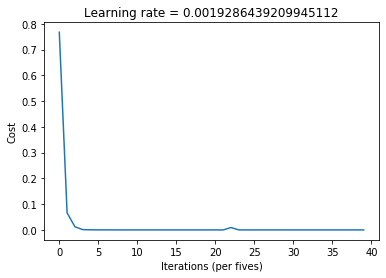

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9782993

Learning rate: 0.4119302380376908
Cost after epoch 0: 55.737595
Cost after epoch 100: 4.856717


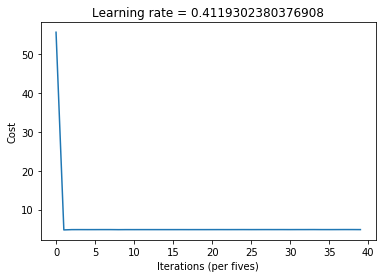

Parameters trained!
Train Accuracy:  0.09915452
Cross-Validation Accuracy:  0.09707483

Learning rate: 0.008288573963901116
Cost after epoch 0: 0.535359
Cost after epoch 100: 0.054719


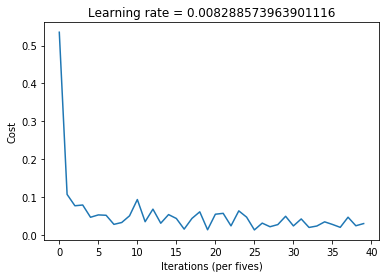

Parameters trained!
Train Accuracy:  0.99862975
Cross-Validation Accuracy:  0.97183675

No. of hidden units: 424

Learning rate: 0.07738767886265063
Cost after epoch 0: 2.760466
Cost after epoch 100: 0.761300


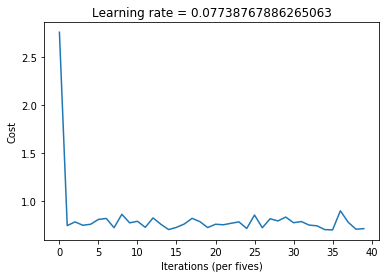

Parameters trained!
Train Accuracy:  0.88956267
Cross-Validation Accuracy:  0.8572789

Learning rate: 0.21262097243064185
Cost after epoch 0: 18.462449
Cost after epoch 100: 3.801372


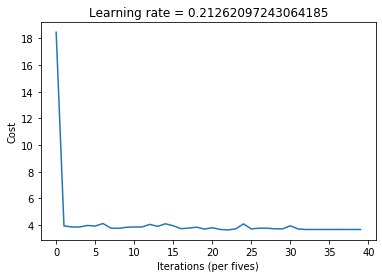

Parameters trained!
Train Accuracy:  0.30985424
Cross-Validation Accuracy:  0.30544218

Learning rate: 0.0011892993902712177
Cost after epoch 0: 0.907885
Cost after epoch 100: 0.000001


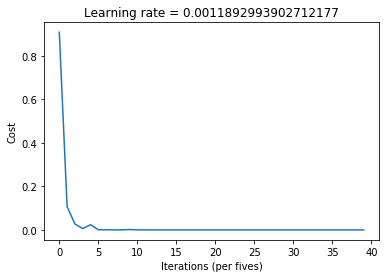

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9765306

Learning rate: 0.001207546650657428
Cost after epoch 0: 0.907220
Cost after epoch 100: 0.000003


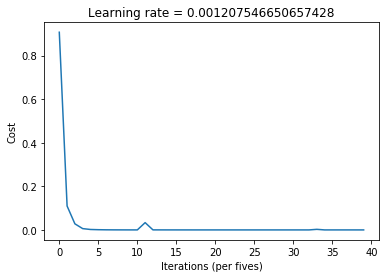

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97591835

Learning rate: 0.0017193215824340233
Cost after epoch 0: 0.818109
Cost after epoch 100: 0.000000


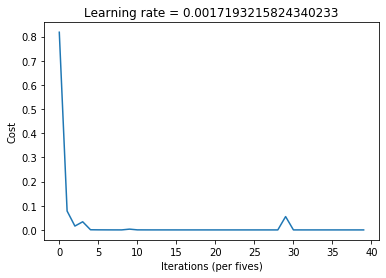

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97741497

Learning rate: 0.0034232833382602675
Cost after epoch 0: 0.654279
Cost after epoch 100: 0.011563


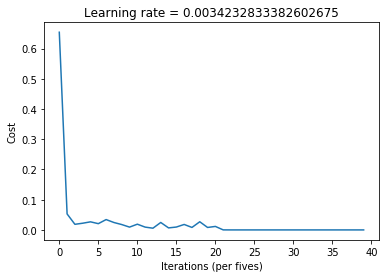

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9782993

Learning rate: 0.6340725780813288
Cost after epoch 0: 138.553689
Cost after epoch 100: 4.876362


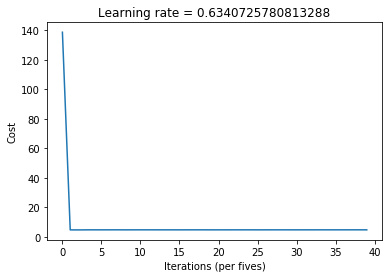

Parameters trained!
Train Accuracy:  0.09953353
Cross-Validation Accuracy:  0.10068027

Learning rate: 0.0019286439209945112
Cost after epoch 0: 0.787430
Cost after epoch 100: 0.000000


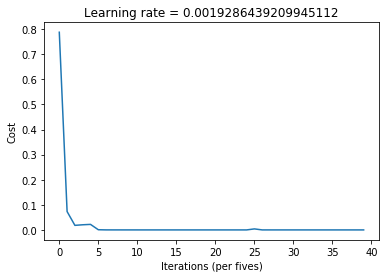

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9782313

Learning rate: 0.4119302380376908
Cost after epoch 0: 87.238011
Cost after epoch 100: 4.818290


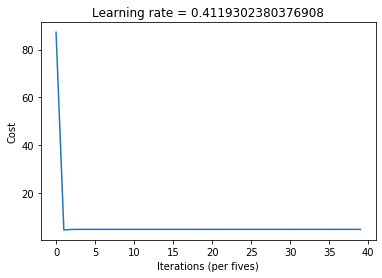

Parameters trained!
Train Accuracy:  0.10766764
Cross-Validation Accuracy:  0.10428572

Learning rate: 0.008288573963901116
Cost after epoch 0: 0.539232
Cost after epoch 100: 0.058770


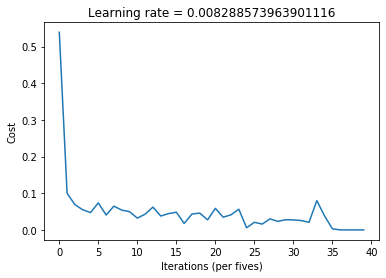

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97571427

No. of hidden units: 731

Learning rate: 0.07738767886265063
Cost after epoch 0: 4.185300
Cost after epoch 100: 0.747492


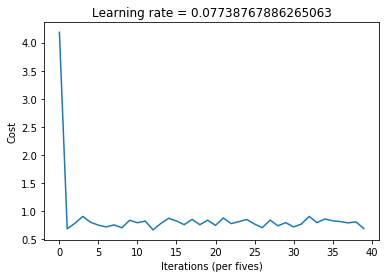

Parameters trained!
Train Accuracy:  0.8945481
Cross-Validation Accuracy:  0.86965984

Learning rate: 0.21262097243064185
Cost after epoch 0: 35.520857
Cost after epoch 100: 3.621731


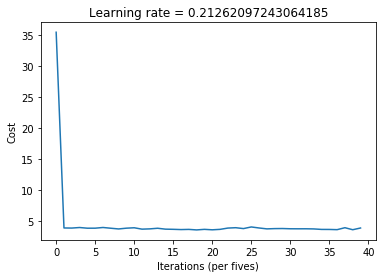

Parameters trained!
Train Accuracy:  0.2699417
Cross-Validation Accuracy:  0.2670068

Learning rate: 0.0011892993902712177
Cost after epoch 0: 0.812135
Cost after epoch 100: 0.000000


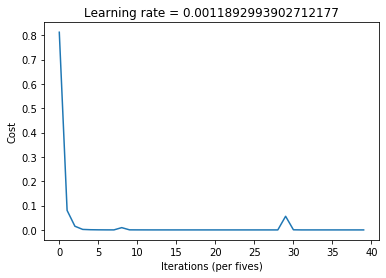

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97809523

Learning rate: 0.001207546650657428
Cost after epoch 0: 0.804476
Cost after epoch 100: 0.000000


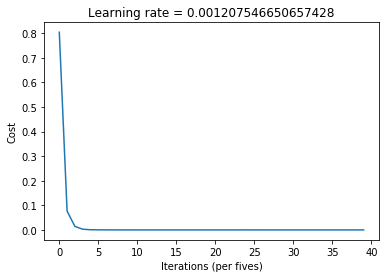

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97945577

Learning rate: 0.0017193215824340233
Cost after epoch 0: 0.728792
Cost after epoch 100: 0.000000


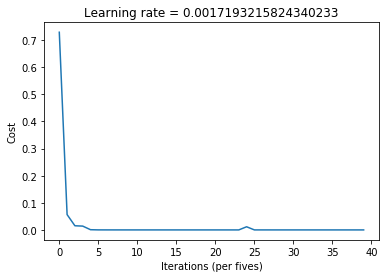

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9792517

Learning rate: 0.0034232833382602675
Cost after epoch 0: 0.599124
Cost after epoch 100: 0.012973


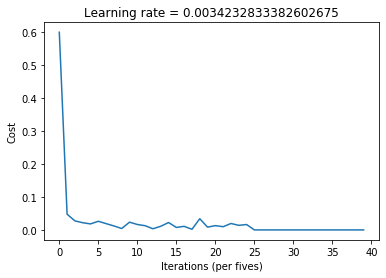

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9787755

Learning rate: 0.6340725780813288
Cost after epoch 0: 311.193621
Cost after epoch 100: 4.871980


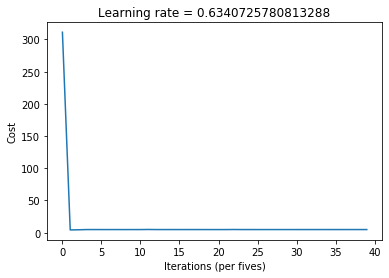

Parameters trained!
Train Accuracy:  0.09985423
Cross-Validation Accuracy:  0.10047619

Learning rate: 0.0019286439209945112
Cost after epoch 0: 0.703907
Cost after epoch 100: 0.000000


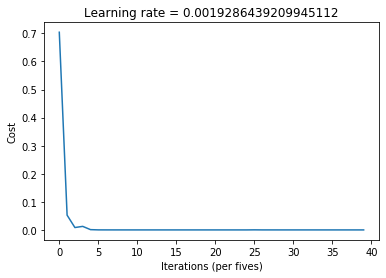

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97952384

Learning rate: 0.4119302380376908
Cost after epoch 0: 107.523119
Cost after epoch 100: 4.855892


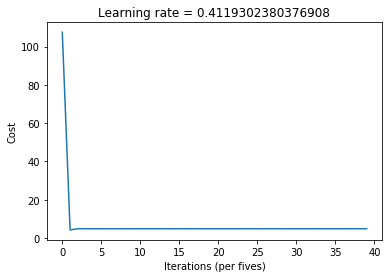

Parameters trained!
Train Accuracy:  0.1003207
Cross-Validation Accuracy:  0.09870748

Learning rate: 0.008288573963901116
Cost after epoch 0: 0.523052
Cost after epoch 100: 0.024869


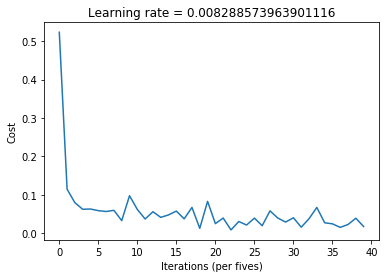

Parameters trained!
Train Accuracy:  0.99918365
Cross-Validation Accuracy:  0.9740136

No. of hidden units: 980

Learning rate: 0.07738767886265063
Cost after epoch 0: 5.773425
Cost after epoch 100: 0.862444


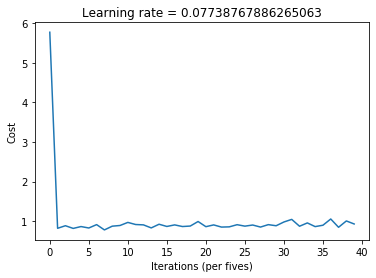

Parameters trained!
Train Accuracy:  0.8880466
Cross-Validation Accuracy:  0.8609524

Learning rate: 0.21262097243064185
Cost after epoch 0: 42.108495
Cost after epoch 100: 3.686888


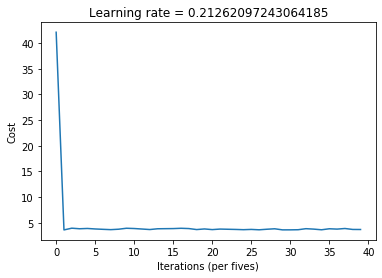

Parameters trained!
Train Accuracy:  0.30489796
Cross-Validation Accuracy:  0.30115646

Learning rate: 0.0011892993902712177
Cost after epoch 0: 0.769827
Cost after epoch 100: 0.000000


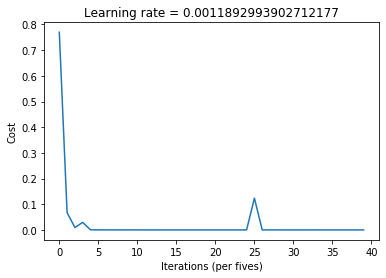

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97986394

Learning rate: 0.001207546650657428
Cost after epoch 0: 0.764824
Cost after epoch 100: 0.000000


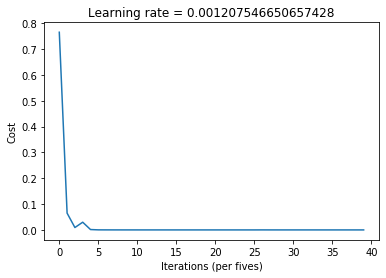

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.9804082

Learning rate: 0.0017193215824340233
Cost after epoch 0: 0.689035
Cost after epoch 100: 0.000000


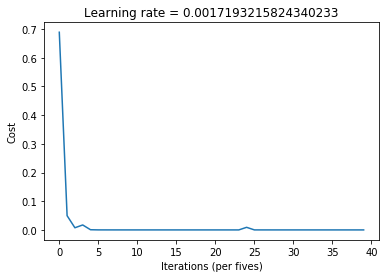

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.98013604

Learning rate: 0.0034232833382602675
Cost after epoch 0: 0.564959
Cost after epoch 100: 0.013140


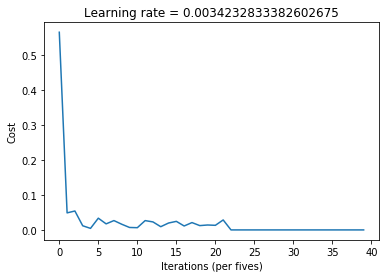

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97931975

Learning rate: 0.6340725780813288
Cost after epoch 0: 339.550885
Cost after epoch 100: 4.873534


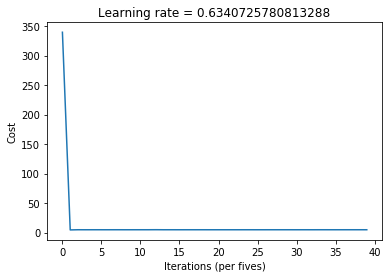

Parameters trained!
Train Accuracy:  0.10020408
Cross-Validation Accuracy:  0.1007483

Learning rate: 0.0019286439209945112
Cost after epoch 0: 0.661056
Cost after epoch 100: 0.000000


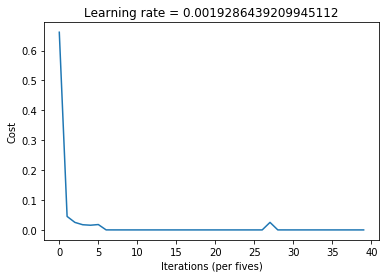

Parameters trained!
Train Accuracy:  1.0
Cross-Validation Accuracy:  0.97986394

Learning rate: 0.4119302380376908
Cost after epoch 0: 138.547193
Cost after epoch 100: 4.839547


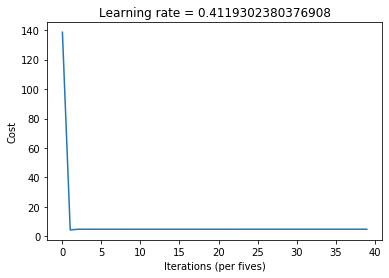

Parameters trained!
Train Accuracy:  0.100816324
Cross-Validation Accuracy:  0.09884354

Learning rate: 0.008288573963901116
Cost after epoch 0: 0.528189
Cost after epoch 100: 0.018511


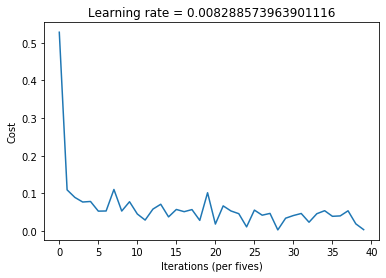

Parameters trained!
Train Accuracy:  0.99897957
Cross-Validation Accuracy:  0.9731973


In [72]:
units = np.squeeze(np.random.randint(50, 1000, [1, 10]))
r = -3 * np.squeeze(np.random.rand(1, 10))
alphas = 10 ** r

for unit in units:
    print("\nNo. of hidden units: " + str(unit))
    for alpha in alphas:
        print("\nLearning rate: " + str(alpha))
        param = model(X_train, Y_train, X_val, Y_val, hidden_units = unit, learning_rate = alpha)